<a href="https://colab.research.google.com/github/jyanivaddi/ERA_V1/blob/master/session_20/S20_StableDiffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone "https://github.com/jyanivaddi/ERA_V1.git"
!git -C ERA_V1 pull

fatal: destination path 'ERA_V1' already exists and is not an empty directory.
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 4 (delta 2), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (4/4), 81.56 KiB | 7.41 MiB/s, done.
From https://github.com/jyanivaddi/ERA_V1
   d22863c..18ed9d7  master     -> origin/master
Updating d22863c..18ed9d7
Fast-forward
 session_20/S20_StableDiffusion.ipynb | 1919 +++++++++++++++++++++++++++++++---
 1 file changed, 1785 insertions(+), 134 deletions(-)


In [2]:
import os
import sys
sys.path.append('/content/ERA_V1/session_20')

In [3]:
%pip install -qq -U datasets transformers pyarrow==9.0.0
%pip install -qq --upgrade transformers==4.25.1 diffusers ftfy accelerate


In [4]:
from huggingface_hub import notebook_login

notebook_login()

In [5]:
%%capture
!sudo apt -qq install git-lfs
!git config --global credential.helper store

In [6]:
from base64 import b64encode

import numpy as np
import torch
from diffusers import AutoencoderKL, LMSDiscreteScheduler, UNet2DConditionModel

from matplotlib import pyplot as plt
from pathlib import Path
from PIL import Image
from torch import autocast
from torchvision import transforms as tfms
from tqdm.auto import tqdm
from transformers import CLIPTextModel, CLIPTokenizer, logging
import os
import cv2
import torchvision.transforms as T

torch.manual_seed(1)
logging.set_verbosity_error()

torch_device = "cuda" if torch.cuda.is_available() else "cpu"


In [7]:
# Load the autoencoder
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder='vae')

# Load tokenizer and text encoder to tokenize and encode the text
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

# Unet model for generating latents
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder='unet')

# Noise scheduler
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)

# Move everything to GPU
vae = vae.to(torch_device)
text_encoder = text_encoder.to(torch_device)
unet = unet.to(torch_device)

**Generate Clip embeddings for input text embeddings**

In [8]:
# Prep Scheduler
def set_timesteps(scheduler, num_inference_steps):
    scheduler.set_timesteps(num_inference_steps)
    scheduler.timesteps = scheduler.timesteps.to(torch.float32) # minor fix to ensure MPS compatibility, fixed in diffusers PR 3925

def get_output_embeds(input_embeddings):
    # CLIP's text model uses causal mask, so we prepare it here:
    bsz, seq_len = input_embeddings.shape[:2]
    causal_attention_mask = text_encoder.text_model._build_causal_attention_mask(bsz, seq_len, dtype=input_embeddings.dtype)

    # Getting the output embeddings involves calling the model with passing output_hidden_states=True
    # so that it doesn't just return the pooled final predictions:
    encoder_outputs = text_encoder.text_model.encoder(
        inputs_embeds=input_embeddings,
        attention_mask=None, # We aren't using an attention mask so that can be None
        causal_attention_mask=causal_attention_mask.to(torch_device),
        output_attentions=None,
        output_hidden_states=True, # We want the output embs not the final output
        return_dict=None,
    )

    # We're interested in the output hidden state only
    output = encoder_outputs[0]

    # There is a final layer norm we need to pass these through
    output = text_encoder.text_model.final_layer_norm(output)

    # And now they're ready!
    return output

**Generate with input embeddings**

**Create custom embeddings**

In [9]:
style_files = ['/content/ERA_V1/session_20/learned_embeds_style_0.bin',
               '/content/ERA_V1/session_20/learned_embeds_style_10.bin',
               '/content/ERA_V1/session_20/learned_embeds_style_2.bin',
               '/content/ERA_V1/session_20/learned_embeds_style_5.bin',
               '/content/ERA_V1/session_20/learned_embeds_style_8.bin']

def get_style_embeddings(style_file):
    style_embed = torch.load(style_file)
    style_name = list(style_embed.keys())[0]
    return style_embed[style_name]

def get_EOS_pos_in_prompt(prompt):
    return len(prompt.split())+1

**Define Custom Loss**

In [40]:
def invert_loss(gen_image):
    inverter = T.RandomInvert(p=1.0)
    inverted_img = inverter(gen_image)
    #loss = torch.abs(gen_image - inverted_img).sum()
    loss = torch.nn.functional.mse_loss(gen_image[:,0], gen_image[:,2]) + torch.nn.functional.mse_loss(gen_image[:,2], gen_image[:,1]) + torch.nn.functional.mse_loss(gen_image[:,0], gen_image[:,1])

    return loss

def blue_loss(images):
    # How far are the blue channel values to 0.9:
    error = torch.abs(images[:,2] - 0.9).mean() # [:,2] -> all images in batch, only the blue channel
    return error



**Get the custom embeddings**

In [29]:
from torchvision.transforms import ToTensor
def pil_to_latent(input_im):
    # Single image -> single latent in a batch (so size 1, 4, 64, 64)
    with torch.no_grad():
        latent = vae.encode(tfms.ToTensor()(input_im).unsqueeze(0).to(torch_device)*2-1) # Note scaling
    return 0.18215 * latent.latent_dist.sample()

def latents_to_pil(latents):
    # bath of latents -> list of images
    latents = (1 / 0.18215) * latents
    with torch.no_grad():
        image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    return pil_images

def additional_guidance(latents, scheduler, noise_pred, t, sigma, custom_loss_fn, custom_loss_scale):
    #### ADDITIONAL GUIDANCE ###
    # Requires grad on the latents
    latents = latents.detach().requires_grad_()

    # Get the predicted x0:
    latents_x0 = latents - sigma * noise_pred
    #print(f"latents: {latents.shape}, noise_pred:{noise_pred.shape}")
    #latents_x0 = scheduler.step(noise_pred, t, latents).pred_original_sample

    # Decode to image space
    denoised_images = vae.decode((1 / 0.18215) * latents_x0).sample / 2 + 0.5 # range (0, 1)

    # Calculate loss
    loss = custom_loss_fn(denoised_images) * custom_loss_scale

    # Get gradient
    cond_grad = torch.autograd.grad(loss, latents, allow_unused=False)[0]

    # Modify the latents based on this gradient
    latents = latents.detach() - cond_grad * sigma**2
    return latents, loss


def generate_with_embs(text_embeddings, max_length, random_seed, loss_fn = None, custom_loss_scale=1.0):

    generator = torch.manual_seed(random_seed)   # Seed generator to create the inital latent noise
    batch_size = 1

    uncond_input = tokenizer(
      [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
    )
    with torch.no_grad():
        uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]
    text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

    # Prep Scheduler
    set_timesteps(scheduler, num_inference_steps)

    # Prep latents
    latents = torch.randn(
    (batch_size, unet.in_channels, height // 8, width // 8),
    generator=generator,
    )
    latents = latents.to(torch_device)
    latents = latents * scheduler.init_noise_sigma

    # Loop
    for i, t in tqdm(enumerate(scheduler.timesteps), total=len(scheduler.timesteps)):
        # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
        latent_model_input = torch.cat([latents] * 2)
        sigma = scheduler.sigmas[i]
        latent_model_input = scheduler.scale_model_input(latent_model_input, t)

        # predict the noise residual
        with torch.no_grad():
            noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

        # perform guidance
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)
        if loss_fn is not None:
            if i%2 == 0:
                latents, custom_loss = additional_guidance(latents, scheduler, noise_pred, t, sigma, loss_fn, custom_loss_scale)
                print(i, 'loss:', custom_loss.item())

        # compute the previous noisy sample x_t -> x_t-1
        latents = scheduler.step(noise_pred, t, latents).prev_sample

    return latents_to_pil(latents)[0]

In [12]:
def generate_image_with_custom_style(prompt, style_num=None, random_seed=41, custom_loss_fn = None, custom_loss_scale=1.0):
    eos_pos = get_EOS_pos_in_prompt(prompt)

    style_token_embedding = None
    if style_num:
        style_token_embedding = get_style_embeddings(style_files[style_num])

    # tokenize
    text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
    max_length = text_input.input_ids.shape[-1]
    input_ids = text_input.input_ids.to(torch_device)

    # get token embeddings
    token_emb_layer = text_encoder.text_model.embeddings.token_embedding
    token_embeddings = token_emb_layer(input_ids)

    # Append style token towards the end of the sentence embeddings
    if style_token_embedding is not None:
        token_embeddings[-1, eos_pos, :] = style_token_embedding

    # combine with pos embs
    pos_emb_layer = text_encoder.text_model.embeddings.position_embedding
    position_ids = text_encoder.text_model.embeddings.position_ids[:, :77]
    position_embeddings = pos_emb_layer(position_ids)
    input_embeddings = token_embeddings + position_embeddings

    #  Feed through to get final output embs
    modified_output_embeddings = get_output_embeds(input_embeddings)

    # And generate an image with this:
    generated_image = generate_with_embs(modified_output_embeddings, max_length, random_seed, custom_loss_fn, custom_loss_scale)
    return generated_image

In [13]:
def show_images(images_list):
    # Let's visualize the four channels of this latent representation:
    fig, axs = plt.subplots(1, len(images_list), figsize=(16, 4))
    for c in range(len(images_list)):
        axs[c].imshow(images_list[c])
    plt.show()

<ipython-input-29-edcdebd8c7d6>:60: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

0 loss: 10.352323532104492
2 loss: 46.07089614868164
4 loss: 0.4669533967971802
6 loss: 2.0092248916625977
8 loss: 1.8049094676971436
10 loss: 2.310439109802246
12 loss: 1.9148815870285034
14 loss: 1.7568070888519287
16 loss: 1.5645616054534912
18 loss: 1.370265007019043
20 loss: 1.325302243232727
22 loss: 1.3393480777740479
24 loss: 1.3815025091171265
26 loss: 1.4522068500518799
28 loss: 1.5476882457733154


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

0 loss: 7.346762657165527
2 loss: 5.432829856872559
4 loss: 2.9584295749664307
6 loss: 2.62955904006958
8 loss: 1.3157391548156738
10 loss: 1.3237733840942383
12 loss: 0.8913925886154175
14 loss: 0.7601898908615112
16 loss: 0.6651156544685364
18 loss: 0.6209447979927063
20 loss: 0.6148712038993835
22 loss: 0.634091854095459
24 loss: 0.6645417809486389
26 loss: 0.7095128297805786
28 loss: 0.7782736420631409


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

0 loss: 12.542076110839844
2 loss: 92.404052734375
4 loss: 2.493680715560913
6 loss: 1.268999457359314
8 loss: 1.0165523290634155
10 loss: 0.9389673471450806
12 loss: 0.9052897095680237
14 loss: 0.8185179233551025
16 loss: 0.7360837459564209
18 loss: 0.7541295886039734
20 loss: 0.7897775769233704
22 loss: 0.8215725421905518
24 loss: 0.8538807034492493
26 loss: 0.8882609009742737
28 loss: 0.9254581928253174


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

0 loss: 3.7195305824279785
2 loss: 30.637937545776367
4 loss: 6.6076765060424805
6 loss: 7.7065534591674805
8 loss: 5.90361213684082
10 loss: 4.219113349914551
12 loss: 4.056854724884033
14 loss: 3.5636022090911865
16 loss: 3.2876811027526855
18 loss: 3.2280662059783936
20 loss: 3.119030475616455
22 loss: 3.135303497314453
24 loss: 3.2217907905578613
26 loss: 3.311586380004883
28 loss: 3.3908653259277344


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

0 loss: 28.384035110473633
2 loss: 24.447864532470703
4 loss: 20.49343490600586
6 loss: 11.60732364654541
8 loss: 6.99738883972168
10 loss: 6.520989418029785
12 loss: 4.902668476104736
14 loss: 4.906974792480469
16 loss: 5.0073394775390625
18 loss: 5.025947570800781
20 loss: 5.089004993438721
22 loss: 5.225759506225586
24 loss: 5.378012180328369
26 loss: 5.5298662185668945
28 loss: 5.667609214782715


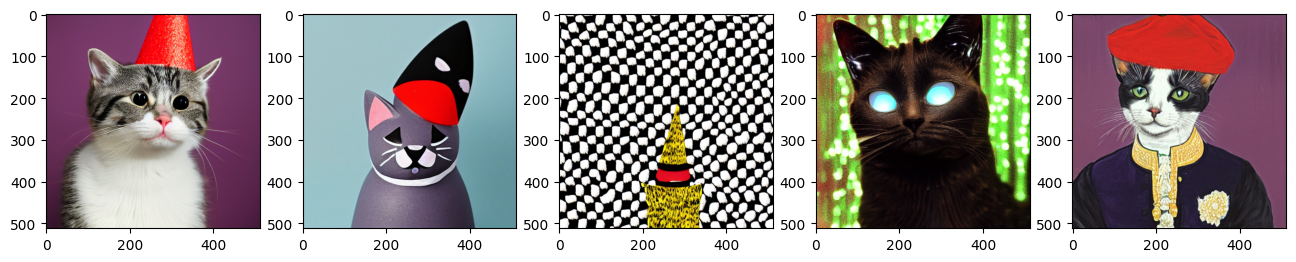

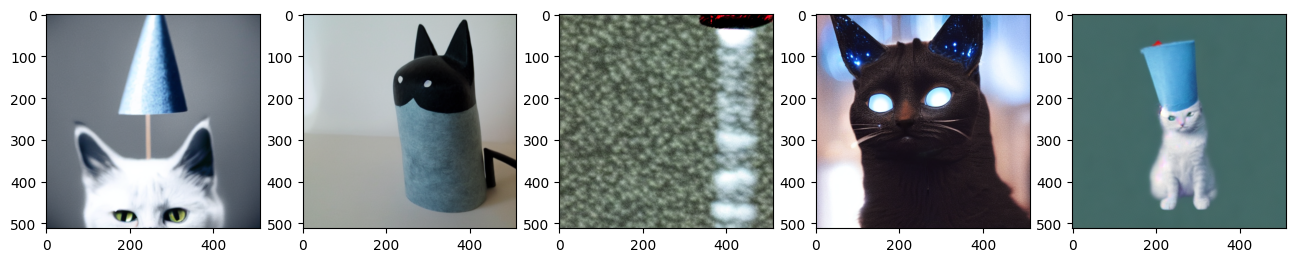

In [42]:
outputs_1 = []
outputs_2 = []
seed_values = [1,2,3,4,5]
height = 512                        # default height of Stable Diffusion
width = 512                         # default width of Stable Diffusion
num_inference_steps = 30            # Number of denoising steps
guidance_scale = 7.5                # Scale for classifier-free guidance
prompt = " A cat wearing a party hat"
custom_loss = invert_loss
#custom_loss_fn = blue_loss
custom_loss_scale = 100.0
num_styles = len(style_files)
for cnt in range(num_styles):
    this_generated_img_1 = generate_image_with_custom_style(prompt,
                                                          style_num = cnt,
                                                          random_seed = seed_values[cnt],
                                                          custom_loss_fn = None,
                                                          custom_loss_scale = custom_loss_scale)
    outputs_1.append(this_generated_img_1)
    this_generated_img_2 = generate_image_with_custom_style(prompt,
                                                          style_num = cnt,
                                                          random_seed = seed_values[cnt],
                                                          custom_loss_fn = invert_loss,
                                                          custom_loss_scale = custom_loss_scale)
    outputs_2.append(this_generated_img_2)


show_images(outputs_1)
show_images(outputs_2)


